In [43]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [44]:
# Read the RGB image
image = cv2.imread('/content/download (2).jfif')
image = image.astype('float32') / 255.0
image = cv2.resize(image,(500,500))
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

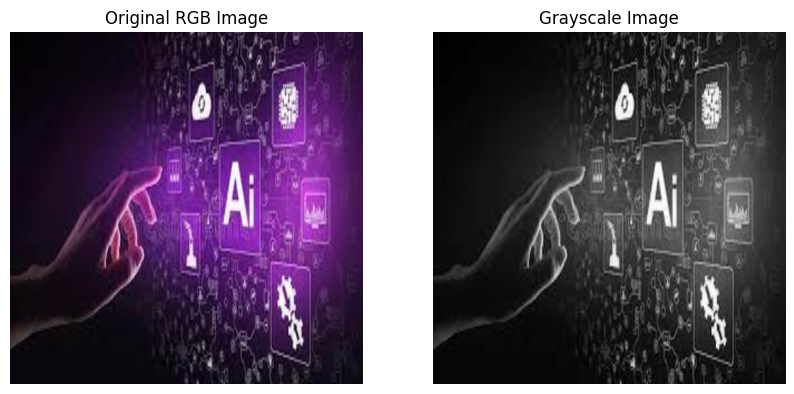

In [45]:
# Visualize the original and grayscale image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

In [46]:
def add_gaussian_noise(image, noise_factor=0.05):
    noisy_image = np.clip(image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape), 0.0, 1.0)
    return noisy_image

In [47]:
def add_salt_and_pepper_noise(image, noise_factor=0.05):
    noisy_image = np.copy(image)
    salt_and_pepper = np.random.rand(*image.shape) < noise_factor
    noisy_image[salt_and_pepper] = 0 if np.random.rand() < 0.5 else 1
    return noisy_image

In [48]:
# Create noisy images
gaussian_noises = [0.01, 0.05, 0.1]
salt_and_pepper_probs = [0.01, 0.05, 0.1]

gaussian_noisy_images = [add_gaussian_noise(gray_image, noise_factor=noise) for noise in gaussian_noises]
salt_and_pepper_noisy_images = [add_salt_and_pepper_noise(gray_image, noise_factor=prob) for prob in salt_and_pepper_probs]


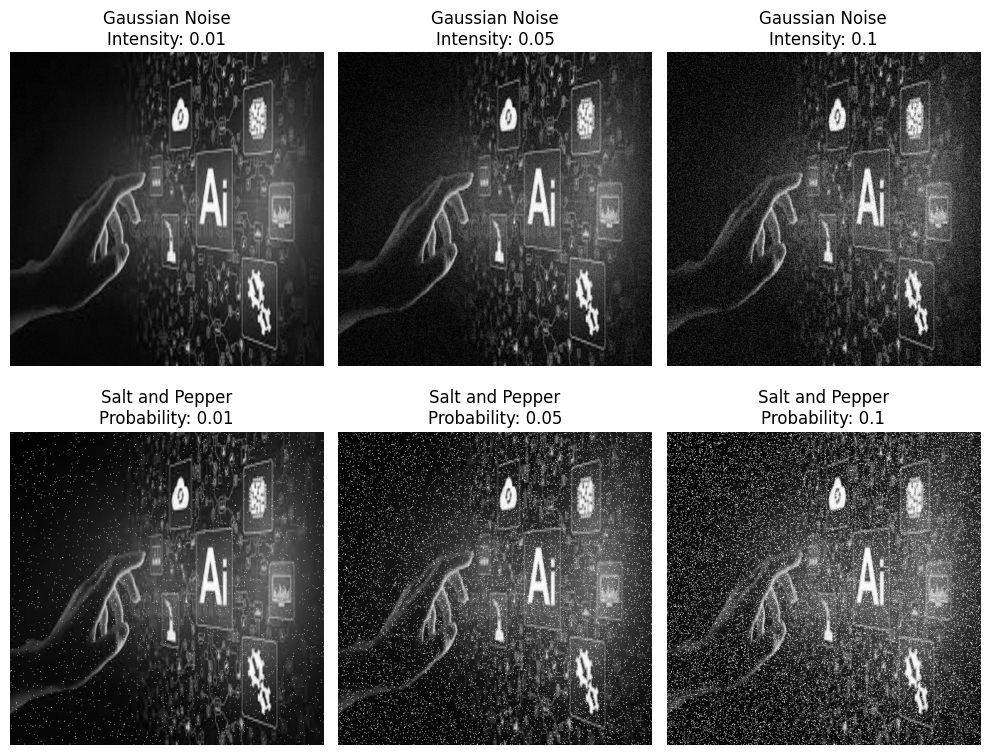

In [49]:
# Plotting
plt.figure(figsize=(10, 8))

for i in range(6):
    plt.subplot(2, 3, i+1)
    if i < 3:
        plt.imshow(gaussian_noisy_images[i], cmap='gray')
        plt.title(f'Gaussian Noise\nIntensity: {gaussian_noises[i]}')
    else:
        plt.imshow(salt_and_pepper_noisy_images[i-3], cmap='gray')
        plt.title(f'Salt and Pepper\nProbability: {salt_and_pepper_probs[i-3]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
# Compute the Discrete Fourier Transform (DFT) of the original image
dft_original = cv2.dft(np.float32(gray_image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift_original = np.fft.fftshift(dft_original)
magnitude_spectrum_original = 20 * np.log(cv2.magnitude(dft_shift_original[:, :, 0], dft_shift_original[:, :, 1]))


In [51]:
# Compute the Discrete Fourier Transform (DFT) of the noisy images
dft_gaussian_noisy = [cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT) for image in gaussian_noisy_images]
dft_salt_and_pepper_noisy = [cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT) for image in salt_and_pepper_noisy_images]

magnitude_spectrum_gaussian_noisy = [20 * np.log(cv2.magnitude(np.fft.fftshift(dft[:, :, 0]), np.fft.fftshift(dft[:, :, 1]))) for dft in dft_gaussian_noisy]
magnitude_spectrum_salt_and_pepper_noisy = [20 * np.log(cv2.magnitude(np.fft.fftshift(dft[:, :, 0]), np.fft.fftshift(dft[:, :, 1]))) for dft in dft_salt_and_pepper_noisy]


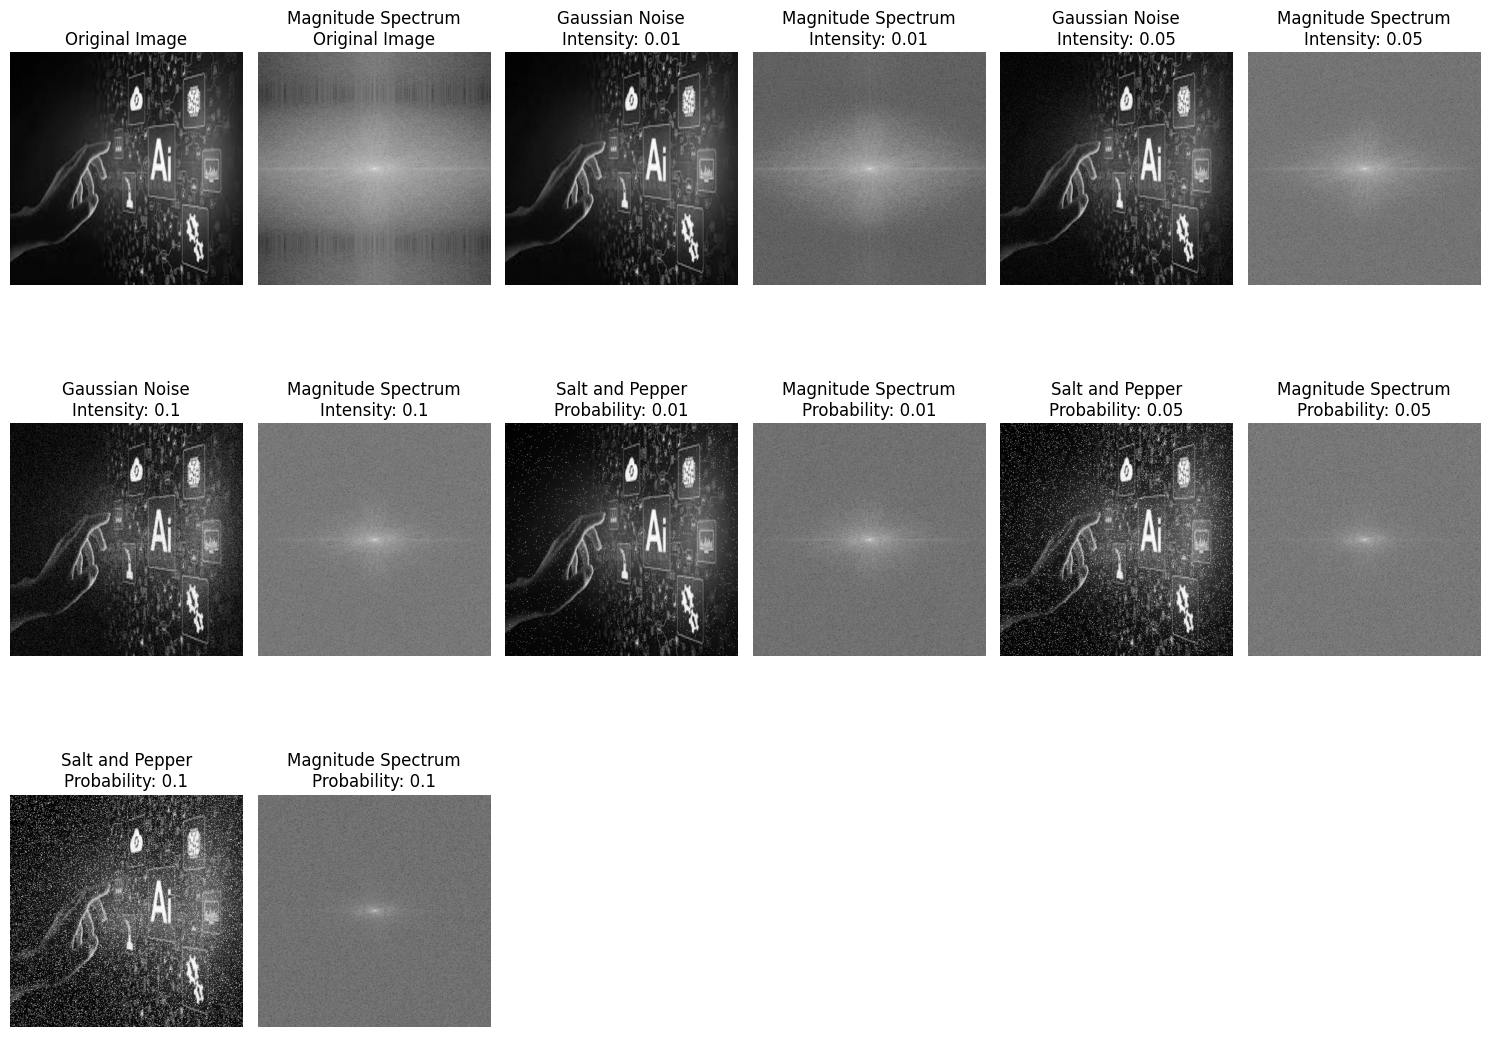

In [52]:
# Plotting
plt.figure(figsize=(15, 15))

# Original image and its magnitude spectrum
plt.subplot(4, 6, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(4, 6, 2)
plt.imshow(magnitude_spectrum_original, cmap='gray')
plt.title('Magnitude Spectrum\nOriginal Image')
plt.axis('off')

# Gaussian noisy images and their magnitude spectra
for i in range(3):
    plt.subplot(4, 6, i*2 + 3)
    plt.imshow(gaussian_noisy_images[i], cmap='gray')
    plt.title(f'Gaussian Noise\nIntensity: {gaussian_noises[i]}')
    plt.axis('off')

    plt.subplot(4, 6, i*2 + 4)
    plt.imshow(magnitude_spectrum_gaussian_noisy[i], cmap='gray')
    plt.title(f'Magnitude Spectrum\nIntensity: {gaussian_noises[i]}')
    plt.axis('off')

# Salt and pepper noisy images and their magnitude spectra
for i in range(3):
    plt.subplot(4, 6, i*2 + 9)
    plt.imshow(salt_and_pepper_noisy_images[i], cmap='gray')
    plt.title(f'Salt and Pepper\nProbability: {salt_and_pepper_probs[i]}')
    plt.axis('off')

    plt.subplot(4, 6, i*2 + 10)
    plt.imshow(magnitude_spectrum_salt_and_pepper_noisy[i], cmap='gray')
    plt.title(f'Magnitude Spectrum\nProbability: {salt_and_pepper_probs[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [53]:
# High pass filter function
def high_pass_filter(image, cutoff_frequency=10):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2

    # Create a mask first, center square is 0, remaining all ones
    mask = np.ones((rows, cols, 2), np.uint8)
    mask[crow - cutoff_frequency:crow + cutoff_frequency, ccol - cutoff_frequency:ccol + cutoff_frequency] = 0

    # Apply mask and inverse DFT
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    return img_back

In [54]:
# Apply high pass filter to the original image
high_pass_filtered_original = high_pass_filter(gray_image)

# Apply high pass filter to the noisy images
high_pass_filtered_gaussian_noisy = [high_pass_filter(image) for image in gaussian_noisy_images]
high_pass_filtered_salt_and_pepper_noisy = [high_pass_filter(image) for image in salt_and_pepper_noisy_images]


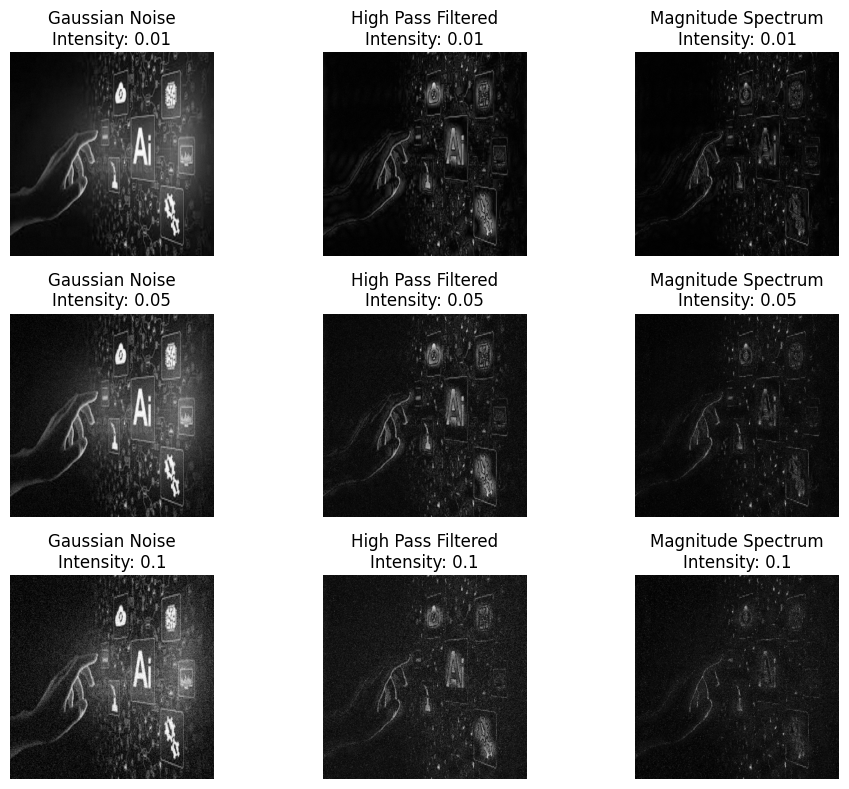

In [55]:
# Plotting
plt.figure(figsize=(10, 8))

# Gaussian noisy images, their high pass filtered versions, and their magnitude spectra
for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(gaussian_noisy_images[i], cmap='gray')
    plt.title(f'Gaussian Noise\nIntensity: {gaussian_noises[i]}')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(high_pass_filtered_gaussian_noisy[i], cmap='gray')
    plt.title(f'High Pass Filtered\nIntensity: {gaussian_noises[i]}')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(high_pass_filter(high_pass_filtered_gaussian_noisy[i]), cmap='gray')
    plt.title(f'Magnitude Spectrum\nIntensity: {gaussian_noises[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


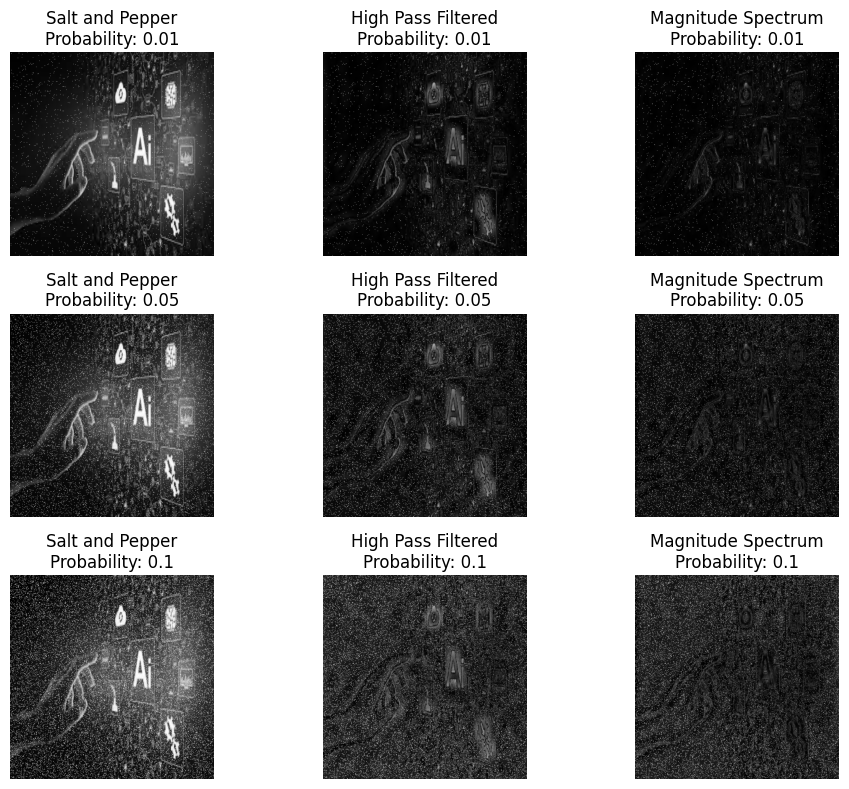

In [56]:
plt.figure(figsize=(10, 8))

# Salt and pepper noisy images, their high pass filtered versions, and their magnitude spectra
for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(salt_and_pepper_noisy_images[i], cmap='gray')
    plt.title(f'Salt and Pepper\nProbability: {salt_and_pepper_probs[i]}')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(high_pass_filtered_salt_and_pepper_noisy[i], cmap='gray')
    plt.title(f'High Pass Filtered\nProbability: {salt_and_pepper_probs[i]}')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(high_pass_filter(high_pass_filtered_salt_and_pepper_noisy[i]), cmap='gray')
    plt.title(f'Magnitude Spectrum\nProbability: {salt_and_pepper_probs[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()